'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


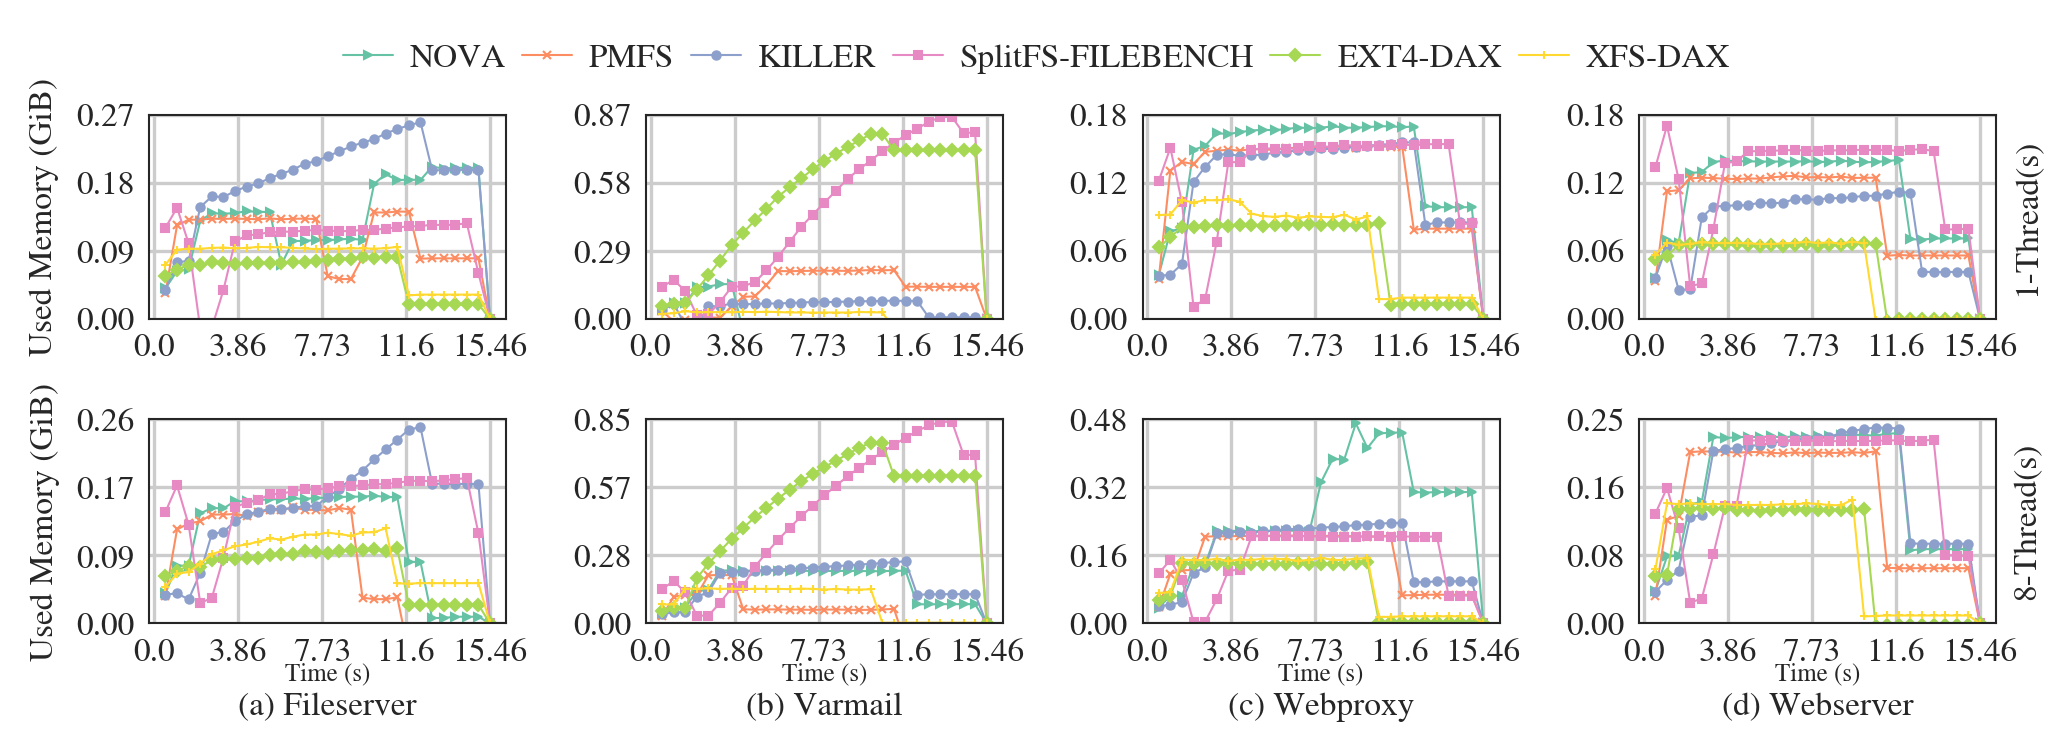

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import sys

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH", "EXT4-DAX", "XFS-DAX"]
workloads = [ "fileserver.f", "varmail.f", "webproxy.f", "webserver.f" ]
workloads_remap = [ "(a) Fileserver", "(b) Varmail", "(c) Webproxy", "(d) Webserver" ]
jobs = [ 1, 8 ]

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))

min_len = sys.maxsize
max_len = 0
for job in jobs:
    for workload in workloads:
        mem_tables = []
        for fs in fss:
            with open("./MEM_DATA/mem-table-{}-{}-{}".format(workload, job, fs), "r") as f:
                df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
                mem_tables.append((df['Memory(KiB)'].iloc[100]/1024/1024 - df['Memory(KiB)']/1024/1024).tolist())
                if len(df) < min_len:
                    min_len = len(df)
                if len(df) > max_len:
                    max_len = len(df)

        for mem_table in mem_tables:
            # print(len(mem_table))
            # del mem_table[min_len : ]
            if len(mem_table) < max_len:
                mem_table += [mem_table[-1]] * (max_len - len(mem_table))

        max_mem = 0
        start = 100
        for mem_table in mem_tables:
            new_mem_table = []
            for i in range(len(mem_table)):
                if i > start:
                    if i % 50 == 0:
                        new_mem_table.append(mem_table[i])
            new_mem_table.append(0)
            mem_tables[mem_tables.index(mem_table)] = new_mem_table
            if max(new_mem_table) > max_mem:
                max_mem = max(new_mem_table)

        subfig = plt.subplot(2, 4, jobs.index(job) * len(workloads) + workloads.index(workload) + 1)
        line_width = 0.5
        # colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
        marks = [">", "x", "o", "s", "D", "+"]
        num_jobs = list(range(1, len(mem_tables[0]) + 1))
        for idx, fs in enumerate(fss):
            plt.plot(num_jobs, mem_tables[idx], color=plt.get_cmap('Set2')(idx), markerfacecolor=plt.get_cmap('Set2')(idx), linewidth=line_width, label=fs, marker=marks[idx], markeredgecolor=plt.get_cmap('Set2')(idx), markersize=2, markeredgewidth=0.5)
            # plt.scatter(num_jobs, mem_tables[idx], color=plt.get_cmap('Set2')(idx), s=1)

        plt.xticks(np.linspace(0, len(mem_tables[0]), 5), [ round(label, 2) for label in np.linspace(0, max_len / 100, 5)], fontsize=8)
        plt.ylim(0, max_mem + 0.01)
        plt.yticks(np.linspace(0, max_mem + 0.01, 4), fontsize=8)
        # format y
        plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
        if jobs.index(job) == 1:
            subfig.text(0.5, -0.25, "Time (s)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)    
            plt.xlabel(workloads_remap[workloads.index(workload)], fontsize=8, labelpad=6) 
        if workloads.index(workload) == 0:
            plt.ylabel('Used Memory (GiB)', fontsize=8)
            
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        if workloads.index(workload) == 3:
            ax.set_ylabel(str(job) + "-Thread(s)", fontsize=8)
            ax.yaxis.set_label_position("right")
        


fig.legend(fss, loc='center', bbox_to_anchor=(0.5, 1), ncol=6, fontsize=8, columnspacing=0.5, handletextpad=0.5, handlelength=1.5)
plt.tight_layout()
plt.savefig("./FIG-Mem.pdf", bbox_inches='tight', pad_inches=0)
